## (Stereo) Visual Odometry

In [510]:
import cv2
import numpy as np
import datetime
import matplotlib.pyplot as plt

### Dataset Handling
Let's make a dataset handling object to make our data more accessible as we complete our task.

In [511]:
class Dataset_Handler():
    def __init__(self, lidar=False, progress_bar=True):
        import pandas as pd
        import os
        import cv2

        self.left_image_files = os.listdir('./data/image_02/data')
        self.right_image_files = os.listdir('./data/image_03/data')
        self.left_image_files.sort()
        self.right_image_files.sort()

        self.num_frames = len(self.left_image_files)

        self.reset_frames()
            # Store original frame to memory for testing functions
        self.first_image_left = cv2.imread('./data/image_02/data/' 
                                               + self.left_image_files[0], 0)
        
        self.first_image_right = cv2.imread('./data/image_03/data/' 
                                               + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread('./data/image_02/data/' 
                                               + self.left_image_files[1], 0)
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
            
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread('./data/image_02/data/'+ name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread('./data/image_03/data/' + name_right, 0)
                            for name_right in self.right_image_files)

#### disparity map and depth map
Generate Depth map from stereo images

In [512]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    '''
    Takes a left and right stereo pair of images and computes the disparity map for the left
    image. Pass rgb=True if the images are RGB.
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb -- (bool) set to True if passing RGB images as input
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    #try to tweak these values
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

Time to compute disparity map using StereoSGBM: 0:00:00.056004


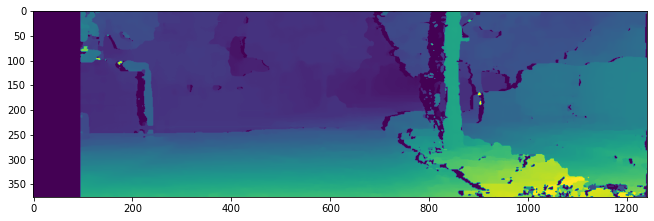

In [513]:
handler = Dataset_Handler()
left = handler.first_image_left
right = handler.first_image_right
disp = compute_left_disparity_map(left, 
                                  right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)

In [514]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

In [515]:
P0 = np.array([[7.188560e+02 ,   0.    ,  6.071928e+02,   4.538225e+01],
               [  0.    ,7.188560e+02 , 1.852157e+02,   -1.130887e-01],
               [  0.    ,   0.    ,   1.    ,   3.779761e-03]])
P1 = np.array([[7.188560e+02 ,   0.    ,  6.071928e+02,   -3.372877e+02],
               [  0.    ,7.188560e+02 , 1.852157e+02,   2.369057e+00],
               [  0.    ,   0.    ,   1.    ,   4.915215e-03]])


Time to compute disparity map using StereoSGBM: 0:00:00.033978


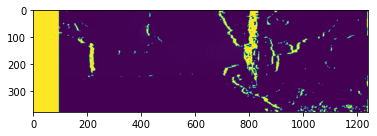

In [516]:
depth = stereo_2_depth(left, 
                       right, 
                       P0, 
                       P1,
                       matcher='sgbm',
                       verbose=True)
plt.imshow(depth)

In [517]:
# Constructing mask using this information
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)

### Your task:

In [518]:
def extract_features(image, mask, detector='orb'):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image
    mask -- Masks for each input image specifying where to look for keypoints

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector=="orb":
        orb = cv2.ORB_create(nfeatures=500)
        kp, des = orb.detectAndCompute(image, mask)
    elif detector=="sift": 
        sift = cv2.SIFT_create()
        kp = sift.detect(image,None)
        kp,des = sift.compute(image,kp)
    elif detector=="brief":   ##BRIEF paired with FAST
        star = cv.xfeatures2d.StarDetector_create()
        brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
        kp = star.detect(img,None)
        kp, des = brief.compute(img, kp)

    return kp, des

In [519]:
import cv2 as cv
def match_features(des1, des2, matching='BF', detector='sift', k=2):
    """
    Match features from two images
    You can set nfeatures to 500 for a faster computation

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    
    
#     matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
#     matches = matcher.knnMatch(des1, des2, 2)

    matchingM=matching.lower()
    detectorM=detector.lower()
    if matchingM=="bf" and detectorM=="sift":
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1,des2, k=2)
    elif matchingM=="bf" and detectorM=="orb":
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1,des2)
#         matches = sorted(matches, key = lambda x:x.distance)  #sorting them in order of their distance
    elif matchingM=="flann" and (detectorM=="sift" or detectorM=="surf") :
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(des1,des2,k=2)
    elif matchingM=="flann" and detectorM=="orb":
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm = FLANN_INDEX_LSH,
                            table_number = 6,
                            key_size = 12,
                            multi_probe_level = 1)
        search_params = dict(checks = 50)
        # Initiate FLANN matcher
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        # Find matches with FLANN
        matches = flann.knnMatch(des1, des2, k=2)

    print(len(matches))
    return matches

In [520]:
def filter_matches_distance(matches, dist_threshold, detector, matcher):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """

    if detector.lower()=="sift" and matcher.lower()=="bf":
        filtered_match=[]
        for m,n in matches:
            if m.distance < dist_threshold*n.distance:
                filtered_match.append([m])
    elif detector.lower()=="sift" and matcher.lower()=="flann":
        filtered_match=[]
        for i,(m,n) in enumerate(matches):
            if m.distance < dist_threshold*n.distance:
                filtered_match[i]=[1,0]
    elif detector.lower()=="orb" and matcher.lower()=="flann":
        filtered_match = []
        ml=len(matches)
        i=0
        for (m,n) in matches:
            if m.distance < dist_threshold * n.distance:
                filtered_match.append(m) 
            i+=1

    else:
        return matches
           

    
    return filtered_match

In [521]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [522]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera intrinsic calibration matrix 
    
    Optional arguments:
    depth1 -- Depth map of the first frame. Set to None to use Essential Matrix decomposition
    max_depth -- Threshold of depth to ignore matched features. 3000 is default

    Returns:
    rmat -- estimated 3x3 rotation matrix
    tvec -- estimated 3x1 translation vector
    image1_points -- matched feature pixel coordinates in the first image. 
                     image1_points[i] = [u, v] -> pixel coordinates of i-th match
    image2_points -- matched feature pixel coordinates in the second image. 
                     image2_points[i] = [u, v] -> pixel coordinates of i-th match
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    
    objectpoints = []
    
    # Iterate through the matched features
    for m in match:
        # Get the pixel coordinates of features f[k - 1] and f[k]
        u1, v1 = kp1[m.queryIdx].pt
        u2, v2 = kp2[m.trainIdx].pt
        
        # Get the scale of features f[k - 1] from the depth map
        s = depth1[int(v1), int(u1)]
        
        # Check for valid scale values
        if s < 1000:
            # Transform pixel coordinates to camera coordinates using the pinhole camera model
            p_c = np.linalg.inv(k) @ (s * np.array([u1, v1, 1]))
            
            # Save the results
            image1_points.append([u1, v1])
            image2_points.append([u2, v2])
            objectpoints.append(p_c)
        
    # Convert lists to numpy arrays
    objectpoints = np.vstack(objectpoints)
    imagepoints = np.array(image2_points)
    
    # Determine the camera pose from the Perspective-n-Point solution using the RANSAC scheme
    _, rvec, tvec, _ = cv2.solvePnPRansac(objectpoints, imagepoints, k, None)
    
    # Convert rotation vector to rotation matrix
    rmat, _ = cv2.Rodrigues(rvec)

    return rmat, tvec, image1_points, image2_points

### check your implementation here

Time to compute disparity map using StereoSGBM: 0:00:00.049823
500
Number of matches before filtering: 500
Number of matches after filtering: 200


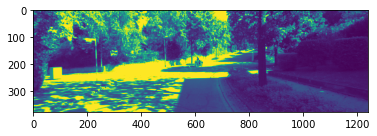

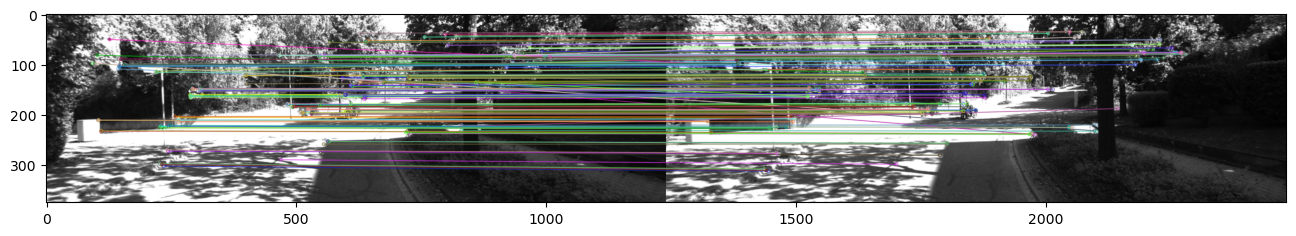

In [523]:
def checkImplementation(descriptor, matcher, ratio):
    #descriptor of type: orb/sift/brief
    #matcher of type: bf/flann
    #ratio: float
    image_left = handler.first_image_left
    plt.imshow(image_left)
    image_right = handler.first_image_right 
    image_plus1 = handler.second_image_left 
    depth = stereo_2_depth(image_left, image_right, P0,  P1, matcher='sgbm', verbose=True) 
    kp0, des0 = extract_features(image_left, None, descriptor) 
    kp1, des1 = extract_features(image_plus1, None, descriptor) 
    matches = match_features(des0, des1, matching=matcher, detector=descriptor) 
    print('Number of matches before filtering:', len(matches)) 
    matches = filter_matches_distance(matches, ratio, descriptor, matcher) 
    print('Number of matches after filtering:', len(matches)) 
    visualize_matches(image_left, kp0, image_plus1, kp1, matches)
    
checkImplementation("orb","flann", .8)

In [524]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None,
                    stereo_matcher='sgbm', mask=None, depth_type='stereo'):
    '''
    Function to perform visual odometry on a sequence from the KITTI visual odometry dataset.
    Takes as input a Data_Handler object and optional parameters.

    Arguments:
    handler -- Data_Handler object instance

    Optional Arguments:
    detector -- (str) can be 'sift' or 'orb'. Default is 'sift'.
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'. Default is 'BF'.
    filter_match_distance -- (float) value for ratio test on matched features. Default is None.
    stereo_matcher -- (str) can be 'bm' (faster) or 'sgbm' (more accurate). Default is 'bm'.
    mask -- (array) mask to reduce feature search area to where depth information available.
    depth_type -- (str) can be 'stereo' or set to None to use Essential matrix decomposition.
                        Note that scale will be incorrect with no depth used.

    Returns:
    trajectory -- Array of shape Nx3x4 of estimated poses of vehicle for each computed frame.

    '''
    num_frames = handler.num_frames
    
    HTM = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = HTM[:3, :]

    # Decompose camera projection matrix to get k matrix
    kl = decompose_projection_matrix(P0)[0]
    handler.reset_frames()
    nextLeftImage = next(handler.images_left) #get first left image
    startTime = datetime.datetime.now()
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        # Get our left and right images
        leftImage = nextLeftImage
        rightImage = next(handler.images_right)
        # Get next frame in the left camera
        nextLeftImage = next(handler.images_left)
        #Estimate depth using stereo_2_depth
        depth = stereo_2_depth(leftImage, rightImage, P0=P0, P1=P1, matcher=stereo_matcher)
        kp0, des0 = extract_features(leftImage, mask, detector)
        kp1, des1 = extract_features(nextLeftImage, mask, detector)
        raw_matches = match_features(des0,
                                        des1,
                                        matching=matching,
                                        detector=detector)

        # Filter matches,  distance of .8 is given.
        matches = filter_matches_distance(raw_matches, .8, detector, matching)
        rotationMatrix, translationMatrix, img1_points, img2_points = estimate_motion(matches, kp0, kp1, kl, depth)
        # blank T matrix
        TransformationMatrix = np.eye(4)
        TransformationMatrix[:3, :3] = rotationMatrix
        TransformationMatrix[:3, 3] = translationMatrix.T
        HTM = HTM.dot(np.linalg.inv(TransformationMatrix))

        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i + 1, :, :] = HTM[:3, :]
        # End the timer for the frame and report frame rate to user
        endTime = datetime.datetime.now()
    print(f'Total time taken: {endTime-startTime}')
    return trajectory

258
253
253
232
223
264
257
251
252
244
240
223
242
260
268
277
316
318
310
283
288
289
305
304
293
325
302
281
274
270
269
272
286
298
281
272
284
273
285
290
287
283
278
287
284
295
302
288
304
287
289
289
303
288
275
287
290
280
265
260
251
256
254
260
271
272
270
272
291
282
277
295
263
274
272
289
282
285
292
283
325
306
304
283
266
272
278
269
280
277
276
262
293
255
260
254
275
272
294
269
295
289
285
279
294
287
305
313
314
316
290
304
291
288
300
281
318
288
282
294
293
289
299
301
292
310
314
309
315
309
317
323
312
313
322
341
375
349
357
372
352
342
335
355
361
355
337
345
335
320
317
307
320
295
311
299
295
278
277
309
299
298
289
292
294
291
274
291
290
289
261
261
274
271
282
271
286
282
291
287
284
273
279
268
272
274
264
275
266
270
267
279
276
283
278
299
277
285
286
282
276
289
296
296
295
289
289
298
288
303
301
321
311
310
301
307
295
300
304
290
274
265
248
246
243
263
260
259
248
254
251
234
252
250
242
234
252
261
259
267
264
260
261
263
280
267
272
284
276
297


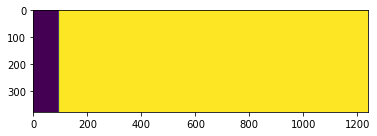

In [532]:
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask)
# You can set nfeatures to 500 and use FLANN based matcher for a faster computation
trajectory = visual_odometry(handler,
                                        filter_match_distance=0.5, 
                                        detector='orb', # you can use your favourite detector and matcher
                                        matching='bf',
                                        stereo_matcher='bm',
                                        mask=mask)

#### Load  gps data
Given that GPS have a noise following a normal distribution of 0 mean and 0.5 standard deviation 

In [533]:
gps_data = np.load('data/gps.npy')
print(gps_data.shape)
print(gps_data[0:5])
x=gps_data[:,0]
x.astype("float64")
y=gps_data[:,1]
x.astype("float64")

(416, 2)
[[-1.77148941  0.44590295]
 [ 0.01294199  0.73860739]
 [ 0.24076167  3.11623914]
 [-0.56993602  1.98862432]
 [-0.86154289  3.04301008]]


array([-1.77148941e+00,  1.29419884e-02,  2.40761672e-01, -5.69936017e-01,
       -8.61542895e-01,  1.81559597e+00, -3.33634142e-01, -4.90624138e-01,
       -1.45083047e-01, -3.96308481e-02, -9.61450912e-01, -8.34988117e-01,
       -3.59976549e-01,  2.90154335e-01,  4.44278537e-01,  4.16809741e-01,
       -1.67299268e+00, -1.26541665e+00,  6.10312287e-01, -4.13032854e-01,
       -9.65160732e-01, -6.20373384e-01, -4.41252287e-01, -7.03020426e-01,
       -1.73675078e-01, -6.34147415e-01, -3.33857054e+00, -1.19967966e+00,
       -1.81202969e+00, -2.07405038e+00, -1.19004543e+00, -1.00584086e+00,
       -1.33473027e+00, -3.38514637e-01, -3.94160315e+00, -3.24183554e+00,
       -3.40336592e+00, -4.38735586e+00, -4.36428110e+00, -2.95481288e+00,
       -5.22827374e+00, -5.00827910e+00, -5.65624061e+00, -5.94268750e+00,
       -7.41293418e+00, -8.74567812e+00, -7.79267017e+00, -1.03700874e+01,
       -1.01354377e+01, -9.99023405e+00, -1.07969809e+01, -1.17367809e+01,
       -1.31154034e+01, -

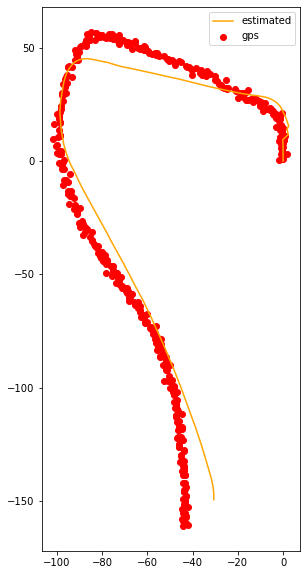

In [534]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.plot(trajectory[:, :, 3][:, 0], 
        trajectory[:, :, 3][:, 2], 
        label='estimated', color='orange')

ax.scatter(gps_data[:,0],gps_data[:,1],
        label='gps',color='red')
ax.legend()

##### You might need this in following part

In [535]:
delta_pose = np.zeros((handler.num_frames-1,2))
bearing = np.zeros(handler.num_frames)
relative_angle = np.zeros(handler.num_frames-1)
distance = np.zeros(handler.num_frames-1)
for i in range(1,handler.num_frames):
    delta_pose[i-1,0] = trajectory[:, :, 3][i,0]-trajectory[:, :, 3][i-1,0]
    delta_pose[i-1,1] = trajectory[:, :, 3][i,2]-trajectory[:, :, 3][i-1,2]
    bearing[i] = np.arctan2(delta_pose[i-1,0],delta_pose[i-1,1])
    relative_angle[i-1] = bearing[i] - bearing[i-1]
    distance[i-1] = np.sqrt(np.square(delta_pose[i-1,0]) + np.square(delta_pose[i-1,1]))
    
print(len(relative_angle))

415




For simplicity, set the state vector X = \begin{bmatrix}
 b \\
 x \\
 y
\end{bmatrix}
### Motion Model
\begin{align}
\mathbf{x}_{k} &= 
\begin{bmatrix}
1 &0 & 0 \\
0 &1 & 0\\
0 &0 & 1
\end{bmatrix}
\mathbf{x}_{k-1} +
\begin{bmatrix}
1 &0 \\
0 &sin(b)\\
0 &cos(b)
\end{bmatrix}
\left(
\begin{bmatrix}
\theta \\
d
\end{bmatrix}
+ \mathbf{w}_k
\right)
\, , \, \, \, \, \, \mathbf{w}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{Q}\right)
\end{align}

- $\mathbf{x}_k = \left[ b \, x \, y  \right]^T$ is the current bearing and 2d position of the vehicle
- $\theta $ is the change in bearing between frame k-1 and k, data is stored in "relative_angle"
- $d$ is the distance traveled between frame k-1 and k, data is stored in "distance"

The process noise $\mathbf{w}_k$ has a (zero mean) normal distribution with a constant covariance $\mathbf{Q}$.


### Measurement Model

The measurement model from gps $\mathbf{y}_k = \left[x \, y \right]^T$.

\begin{align}
\mathbf{y}_k =
\begin{bmatrix}
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
x_k
+ \mathbf{n}_k
\, , \, \, \, \, \, \mathbf{n}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}


The gps measurement noise $\mathbf{n}_k$ has a (zero mean) normal distribution with a constant covariance $\mathbf{R}$.

In [539]:
init_x = np.array([0,0,0]) #initial estimate
P_init = np.diag([0, 0, 0]) #initial covariance 3x3 matrix
th_var = 0.01 #theta variance
d_var = 0.01 #distance variance
varx = np.mean(abs(x - np.mean(x))**2)
vary = np.mean(abs(y - np.mean(y))**2)
Q_km = np.diag([th_var, d_var])  # input noise covariance 
cov_y = np.diag([1, 1])  # measurement noise covariance  2x2 matrix

print(f"cov_y: {cov_y}")

x_est = np.zeros([len(relative_angle), 3])  # estimated states, x, y, and theta
P_est = np.zeros([len(relative_angle), 3, 3])  # state covariance matrices  
x_est[0] = init_x # initial state
P_est[0] = P_init # initial state covariance

from numpy.linalg import inv
def measurement_update(data, P_check, lastx):
    
    # 1. Compute measurement Jacobian
    H_k=np.array([[0,1,0],
                 [0,0,1]])
    M_k=np.array([[1,0],
                [0,1]])

    # 2. Compute Kalman Gain DONE

    K_k = P_check.dot(H_k.T).dot(inv(H_k.dot(P_check).dot(H_k.T) + M_k.dot(cov_y).dot(M_k.T)))

    # 3. Correct predicted state
    y_k_l = data #GPS (x,y) measurement 

    y_k_l_predict = np.zeros([2, ])
    y_k_l_predictx=lastx[1]

    

    y_k_l_predicty=lastx[2]
    y_k_l_predict=np.array([y_k_l_predictx,y_k_l_predicty])
    add = K_k.dot(y_k_l - y_k_l_predict.T)
    add = np.array(add).flatten()
    lastx = lastx + add 
    
    # 4. Correct covariance
    P_check = (np.eye(3) - K_k.dot(H_k)).dot(P_check)  ##might need to change np.eye(3) here
    
    return lastx, P_check, K_k
   


cov_y: [[1 0]
 [0 1]]


In [540]:

lastx, P_check, K_k = measurement_update(gps_data[0],P_est[0], x_est[0])


### Motion Model
\begin{align}
\mathbf{x}_{k} &= 
\begin{bmatrix}
1 &0 & 0 \\
0 &1 & 0\\
0 &0 & 1
\end{bmatrix}
\mathbf{x}_{k-1} +
\begin{bmatrix}
1 &0 \\
0 &sin(b)\\
0 &cos(b)
\end{bmatrix}
\left(
\begin{bmatrix}
\theta \\
d
\end{bmatrix}
+ \mathbf{w}_k
\right)
\, , \, \, \, \, \, \mathbf{w}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{Q}\right)
\end{align}

- $\mathbf{x}_k = \left[ b \, x \, y  \right]^T$ is the current bearing and 2d position of the vehicle
- $\theta $ is the change in bearing between frame k-1 and k, data is stored in "relative_angle"
- $d$ is the distance traveled between frame k-1 and k, data is stored in "distance"

The process noise $\mathbf{w}_k$ has a (zero mean) normal distribution with a constant covariance $\mathbf{Q}$.


In [541]:
##PREDICTION
##combine with top
    #### 5. Main Filter Loop #######################################################################
for k in range(1, len(distance)):  # start at 1 because we've set the initial prediciton
    
    lastx = np.zeros((3,), dtype="float32")
    lastx[0] = x_est[k-1, 0]  ##estimate of x
    lastx[1] = x_est[k-1, 1]  ##estimate of y
    lastx[2] = x_est[k-1, 2]  ##estimate of bearing
    P_check = P_est[k-1, :, :]
    
    
    # 1. Update state with odometry readings (Motion Model)   #just propagate through the motion model equation once

    b=lastx[0]
    second_mat=np.mat([[1,0],
                       [0, np.sin(b)],
                       [0, np.cos(b)]])
    theta=relative_angle[k] ##not sure if it should be k or k-1
    d=distance[k] ##not sure if it should be k or k-1
    last_mat=np.mat([[theta], [d]])
    first_result=second_mat.dot(last_mat) 
    
    lastx[0]=lastx[0]+first_result[0]
    lastx[1]=lastx[1]+first_result[1]
    lastx[2]=lastx[2]+first_result[2]   
        # 2. Motion model jacobian with respect to last state
    theta = lastx[2]
    F_km = np.mat([[1,0,0],
                  [0,1,0],
                  [0,0,1]])

    # 3. Motion model jacobian with respect to noise
    L_km = np.mat([[1, 0],
                   [0, np.sin(b)],
                   [0, np.cos(b)]])


    # 4. Propagate uncertainty
    P_check = F_km.dot(P_check).dot(F_km.T) + L_km.dot(Q_km).dot(L_km.T)

    # 5. Update state estimate using GPS measurements
    p_check_hist = []
    
    for i in range(len(gps_data[k])):
        response = measurement_update(gps_data[k], P_check, lastx)
        lastx=response[0]
        P_check=response[1]
        p_check_hist.append(P_check)
    # Set final state predictions for timestep
    x_est[k, 0] = lastx[0]
    x_est[k, 1] = lastx[1]
    x_est[k, 2] = lastx[2]
    P_est[k, :, :] = P_check


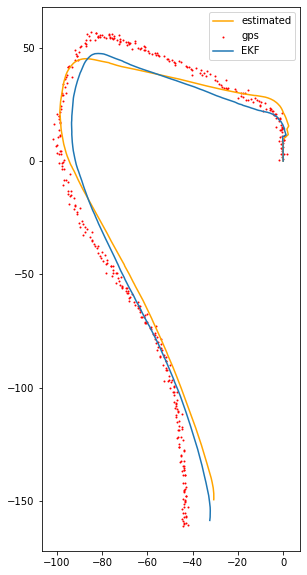

In [542]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.plot(trajectory[:, :, 3][:, 0], 
        trajectory[:, :, 3][:, 2], 
        label='estimated', color='orange')
ax.scatter(gps_data[:,0],gps_data[:,1],
        label='gps',color='red',s=1)
ax.plot(x_est[:,1],x_est[:,2],label='EKF')#plot your EKF result here
ax.legend()